Reference: https://colab.research.google.com/github/angel870326/XLNet_Text_Classification/blob/main/xlnet_multi_class_chinese_english.ipynb

Environment: google colab, GPU T4 selected.

In [1]:
# install packages
!pip install transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00


In [2]:
# import packages
import os
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
%matplotlib inline

In [8]:
# download text pre processing package
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# load google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# build function to clean the text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [13]:
# load training data and test data
train = pd.read_csv('/content/drive/MyDrive/Enron_email/4763.csv')
test = pd.read_csv('/content/drive/MyDrive/Enron_email/1191.csv')

train = train[['Content', 'Label']]  # subset the columns
train.columns = ['Text', 'Sentiment']   # change the column names

test = test[['Content', 'Label']]  # subset the columns
test.columns = ['Text', 'Sentiment']   # change the column names

In [14]:
# Apply the clean_text function to the train and test dataset
train['Text'] = train['Text'].apply(clean_text)
test['Text'] = test['Text'].apply(clean_text)

In [10]:
# get GPU information
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [15]:
# convert labels to dummy variables
sentiment = pd.get_dummies(train['Sentiment'])
train = pd.concat([train, sentiment], axis=1)
train

,Text,Sentiment,Negative,Neutral,Positive
0,ok let know got extra ticket sent monday novem...,Neutral,0,1,0
1,done sent tuesday november darren update tenas...,Neutral,0,1,0
2,hey phillip already made reservation jeff wait...,Neutral,0,1,0
3,probably wont able go could send people,Negative,1,0,0
4,got elizabeth really want change date let know...,Neutral,0,1,0
...,...,...,...,...,...
4758,summary position trading goal today advise don...,Positive,0,0,1
4759,today sent tuesday june lavorato going buy vac...,Neutral,0,1,0
4760,agreement power assume youre going let people ...,Neutral,0,1,0
4761,msn messenger think im set sent wednesday may ...,Negative,1,0,0


In [16]:
# XLNetTokenizer & Sentence embedding
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    x_ticks = range(0, max(tokenized_texts_len) + 1, int(max(tokenized_texts_len) / 10))
    ax.set_xticks(x_ticks)
    return

In [17]:
# load pre_trained tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [18]:
# get a list of trai and test
train_text_list = train['Text'].values
test_text_list = test['Text'].values

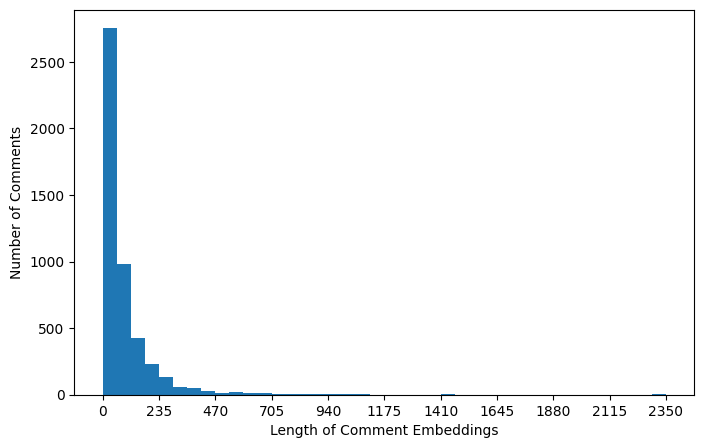

In [19]:
# train test length
plot_sentence_embeddings_length(train_text_list, tokenizer)

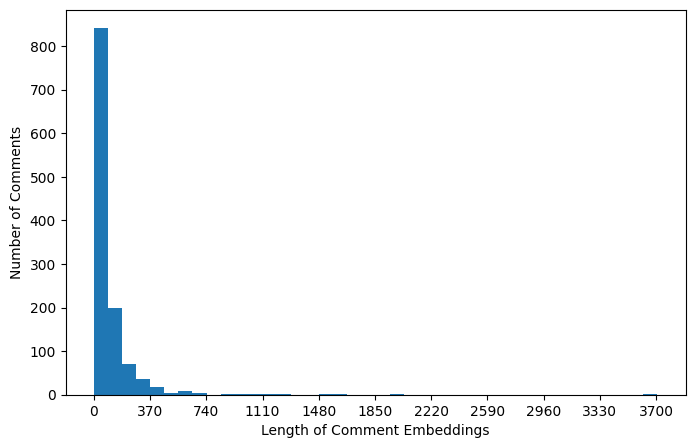

In [20]:
# test text length
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [21]:
# Tokenize input texts into ids
# Append the appropriate special characters to the end of the text to denote end of sentence.
# Truncate or pad the appropriate sequence length.
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [22]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[  17, 3518,  618, ...,    0,    0,    0],
       [ 588,  797,   17, ...,    0,    0,    0],
       [  43,  117,   17, ...,   17,    4,    3],
       ...,
       [ 980,  350, 5544, ...,   17,    4,    3],
       [  17,   98,   23, ...,    0,    0,    0],
       [ 343,  797,   17, ...,    0,    0,    0]])

In [23]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[  451,  3580,   734, ...,     0,     0,     0],
       [11379,  7273,   618, ...,     0,     0,     0],
       [  132,   210,   755, ...,     0,     0,     0],
       ...,
       [  232,  2826,    17, ...,     0,     0,     0],
       [  160,  2087,  4336, ...,     0,     0,     0],
       [ 3883,    17,  1204, ...,     0,     0,     0]])

In [24]:
train_input_ids[0].size

250

In [25]:
# Create attention masks
# Tell model whether attention should be applied to the input id tokens
# we do not want to perform attention on padding tokens.
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [26]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

In [27]:
train_attention_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [28]:
# Add input ids and attention masks to the dataframe
# train
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [29]:
train.head()

,Text,Sentiment,Negative,Neutral,Positive,features,masks
0,ok let know got extra ticket sent monday novem...,Neutral,0,1,0,"[17, 3518, 618, 175, 345, 1588, 4467, 797, 17,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,done sent tuesday november darren update tenas...,Neutral,0,1,0,"[588, 797, 17, 2853, 202, 765, 116, 189, 8405,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,hey phillip already made reservation jeff wait...,Neutral,0,1,0,"[43, 117, 17, 13385, 8562, 427, 140, 12033, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,probably wont able go could send people,Negative,1,0,0,"[885, 282, 46, 551, 216, 121, 1409, 104, 4, 3,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,got elizabeth really want change date let know...,Neutral,0,1,0,"[345, 17, 530, 16798, 1156, 138, 343, 210, 459...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [30]:
test.head()

,Text,Sentiment,features,masks
0,per conversation credit appears two northern s...,Neutral,"[451, 3580, 734, 2050, 87, 1478, 204, 350, 226...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,swim lesson let know going thursday potential ...,Neutral,"[11379, 7273, 618, 175, 223, 17, 138, 1067, 23...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,may want leave time general rockies discussion...,Neutral,"[132, 210, 755, 92, 580, 1796, 1513, 2850, 218...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,two steppin people cant dance great dancer the...,Negative,"[87, 1101, 4640, 104, 64, 46, 2724, 312, 15760...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,ughhhhh sent tuesday october aware latest risk...,Neutral,"[17, 11935, 409, 25997, 797, 17, 2853, 202, 76...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [31]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [32]:
# get X_train and X_valid, Train_masks and valid_masks list
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# label column names
label_cols = sentiment.columns.values.tolist()

# get Y_train and Y_valid list
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [33]:
# Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [34]:
# create dataloader
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader.
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [35]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  for i in trange(num_epochs, desc="Epoch"):    # trange is a tqdm wrapper around the normal python range,
                                                # it is used to extend or enhance the functionality of range by adding a progress bar or other features to it.
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()

      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)

      # Backward pass
      loss.backward()

      # Update parameters and take a step using the computed gradient
      optimizer.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss

      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)

    # if epoch_eval_loss < lowest_eval_loss, set it to lowest_eval_loss, save the model
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

In [36]:
# function for saving the model
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

In [37]:
# function for loading model
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]

  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [38]:
# empty cache
torch.cuda.empty_cache()

In [39]:
# class for the model
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):  # we are not doing MultiLabel but I just try, seems still works.

  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')

    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)

    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits

  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False

  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True

  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state

# initialize the model
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))

In [40]:
# build optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
# Modify output path
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/Enron_email/xlnet2/xlnet.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.03347054575215487
Valid loss: 0.033567087191224476


Epoch:  33%|███▎      | 1/3 [04:51<09:42, 291.10s/it]

Saving model at epoch 0 with validation loss of 0.033567087191224476


Train loss: 0.028227531593146286
Valid loss: 0.026865052026066174


Epoch:  67%|██████▋   | 2/3 [09:43<04:52, 292.07s/it]

Saving model at epoch 1 with validation loss of 0.026865052026066174


Train loss: 0.0240060509189846
Valid loss: 0.026658244861010365


Epoch: 100%|██████████| 3/3 [14:29<00:00, 289.75s/it]

Saving model at epoch 2 with validation loss of 0.026658244861010365




Text(0.5, 1.0, 'Loss vs Number of Epochs')

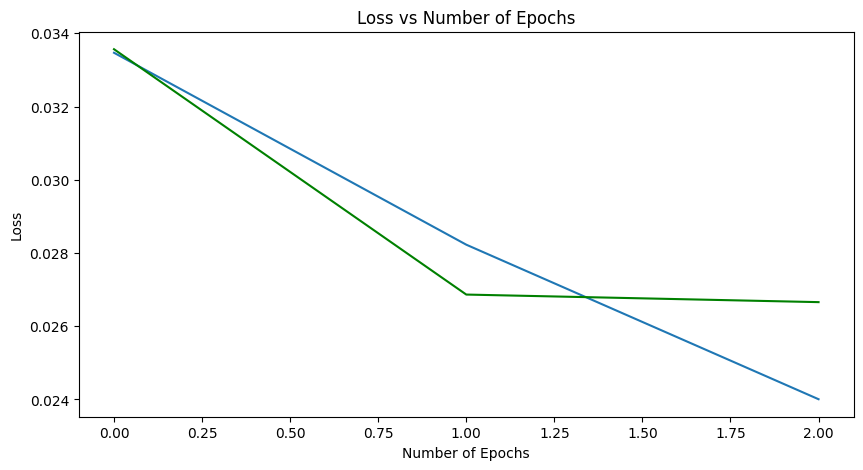

In [42]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")

# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [43]:
# function for predict
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)

  pred_probs = np.array([]).reshape(0, num_labels)

  # sent model to device
  model.to(device)
  model.eval()

  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])

  return pred_probs

In [44]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs # check probability

array([[0.02872174, 0.91215032, 0.07040142],
       [0.02344454, 0.90241444, 0.08299348],
       [0.03129992, 0.87928843, 0.10369643],
       ...,
       [0.25167   , 0.19514669, 0.54834431],
       [0.09850283, 0.37075049, 0.46570468],
       [0.15609005, 0.63340956, 0.20928165]])

In [45]:
# add probability to dataframe
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

,Text,Sentiment,features,masks,Negative,Neutral,Positive
0,per conversation credit appears two northern s...,Neutral,"[451, 3580, 734, 2050, 87, 1478, 204, 350, 226...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.028722,0.912150,0.070401
1,swim lesson let know going thursday potential ...,Neutral,"[11379, 7273, 618, 175, 223, 17, 138, 1067, 23...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.023445,0.902414,0.082993
2,may want leave time general rockies discussion...,Neutral,"[132, 210, 755, 92, 580, 1796, 1513, 2850, 218...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.031300,0.879288,0.103696
3,two steppin people cant dance great dancer the...,Negative,"[87, 1101, 4640, 104, 64, 46, 2724, 312, 15760...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.058250,0.100064,0.827837
4,ughhhhh sent tuesday october aware latest risk...,Neutral,"[17, 11935, 409, 25997, 797, 17, 2853, 202, 76...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.037869,0.804651,0.177948


In [46]:
# Get the maximum probability for each row
test['predict'] = test.iloc[:,4:].idxmax(axis = 1)

In [47]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy overall
accuracy = accuracy_score(test['Sentiment'], test['predict'])
print(f'Overall Accuracy: {accuracy:.2f}')

# Calculate accuracy by class
class_report = classification_report(test['Sentiment'], test['predict'])
print(class_report)

Overall Accuracy: 0.72
              precision    recall  f1-score   support

    Negative       0.39      0.38      0.38       104
     Neutral       0.76      0.90      0.82       764
    Positive       0.74      0.41      0.53       323

    accuracy                           0.72      1191
   macro avg       0.63      0.56      0.58      1191
weighted avg       0.72      0.72      0.70      1191

